# Análise de demonstrativos financeiros
## Indicadores de Eficiência

## 1. Carrega os pacotes

In [1]:
# Carrega as bibliotecas
!pip install wget
!pip install plotnine
import wget # biblioteca para realizar o download de sites
import pandas as pd # biblioteca para manipulação de dados e data frames
from zipfile import ZipFile # biblioteca para extrair arquivo zipados
from plotnine import * # biblioteca para construir o gráfico

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=96e02148967268e88e05a105b4c44522194980e3503f58823b2b7e498572608c
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


## 2. Cria função para coletar demonstrativos da CVM

In [2]:
def download_extract_concatenate_dfp_files(start_year, end_year, financial_statements):
    """
    Função para realizar o download, extração e concatenação de arquivos zipados contendo os dados da Demonstração Financeira
    Padronizada (DFP) de companhias abertas disponibilizados pela Comissão de Valores Mobiliários (CVM).

    Parâmetros:
    start_year (int): Ano inicial da coleta dos dados.
    end_year (int): Ano final da coleta dos dados.
    financial_statements (list): Lista de nomes dos arquivos de demonstrativos financeiros que deseja-se concatenar. Consolidado: BPA_con (balanço patrimonial ativo);
     BPP_con (Balanço patrimonial passivo) DRE_con; DFC_MI_con; DFC_MD_CON; DMPL_con.


    Retorna:
    Arquivo .csv no diretório principal
    """
    url = "https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/DFP/DADOS/"
    # Cria uma lista vazia para inserir os nomes dos arquivos zipados
    arquivo_zipado = []

    # Define os nomes dos arquivos zipados de acordo com o range de datas
    for ano in range(start_year, end_year + 1):
        arquivo_zipado.append(f'dfp_cia_aberta_{ano}.zip')

    # Realiza o download dos arquivos zipados de acordo com a url base
    for arquivos in arquivo_zipado:
        wget.download(url + arquivos)

    # Extrai os arquivos zipados
    for arquivos in arquivo_zipado:
        ZipFile(arquivos, 'r').extractall('DFP')

    # Concatena os dados dos demonstrativos financeiros em um único DataFrame
    for demons in financial_statements:
        arquivo_demonstrativo = pd.DataFrame()
        for ano in range(start_year, end_year + 1):
            arquivo_demonstrativo = pd.concat([arquivo_demonstrativo, pd.read_csv(f'DFP/dfp_cia_aberta_{demons}_{ano}.csv', sep = ';', decimal = ',', encoding = 'ISO-8859-1')])
        arquivo_demonstrativo.to_csv(f'dfp_cia_aberta_{demons}_{start_year}-{end_year}.csv', index = False)

## 3. Coleta os dados

In [3]:
# Coleta os dados da DRE
download_extract_concatenate_dfp_files(2010, 2023, ['DRE_con'])

In [4]:
# Realiza a leitura do arquivo
dre = pd.read_csv('/content/dfp_cia_aberta_DRE_con_2010-2023.csv')

## 4. Tratamento de dados

In [5]:
# Realiza o filtro das contas contábeis, do código CVM e da ordem do exercício
dados = dre[dre.CD_CONTA.isin(["3.01", # Receita de Venda de Bens e/ou Serviços
                                "3.03", # Resultado Bruto
                                "3.05", # EBIT
                                "3.11"  # Lucro/Prejuízo Consolidado do Período
                                 ]) & dre.CD_CVM.isin([12190, 26700, 21431, 19550]) & (dre.ORDEM_EXERC == 'ÚLTIMO')]
# Seleciona as colunas
dados = dados[["DT_REFER", "DENOM_CIA", "CD_CONTA", "DS_CONTA", "VL_CONTA"]]

In [6]:
dados

,DT_REFER,DENOM_CIA,CD_CONTA,DS_CONTA,VL_CONTA
4851,2010-12-31,HYPERA S.A.,3.01,Receita de Venda de Bens e/ou Serviços,3159728.0
4855,2010-12-31,HYPERA S.A.,3.03,Resultado Bruto,1806425.0
4871,2010-12-31,HYPERA S.A.,3.05,Resultado Antes do Resultado Financeiro e dos ...,611956.0
4895,2010-12-31,HYPERA S.A.,3.11,Lucro/Prejuízo Consolidado do Período,261901.0
17232,2010-12-31,BOMBRIL S.A.,3.01,Receita de Venda de Bens e/ou Serviços,804924.0
...,...,...,...,...,...
379325,2023-12-31,EUROFARMA LABORATÓRIOS S.A.,3.11,Lucro/Prejuízo Consolidado do Período,649698.0
380593,2023-12-31,NATURA COSMETICOS S.A.,3.01,Receita de Venda de Bens e/ou Serviços,14928231.0
380597,2023-12-31,NATURA COSMETICOS S.A.,3.03,Resultado Bruto,9890487.0
380613,2023-12-31,NATURA COSMETICOS S.A.,3.05,Resultado Antes do Resultado Financeiro e dos ...,1980386.0


In [7]:
# Converte a coluna de data para datetime
dados['DT_REFER'] = pd.to_datetime(dados['DT_REFER'])

# Cria a coluna Ano
dados['Ano'] = dados['DT_REFER'].dt.year

dados_pivot = dados.pivot(index = ['Ano', 'DENOM_CIA'], columns = 'CD_CONTA', values = 'VL_CONTA')

In [8]:
dados_pivot.head()

CD_CONTA                          3.01       3.03       3.05      3.11
Ano  DENOM_CIA                                                        
2010 BOMBRIL S.A.             804924.0   365924.0    35356.0   28317.0
     HYPERA S.A.             3159728.0  1806425.0   611956.0  261901.0
     NATURA COSMETICOS S.A.  5136712.0  3579906.0  1167906.0  744050.0
2011 BOMBRIL S.A.             845814.0   372181.0    56528.0  -19313.0
     HYPERA S.A.             3324630.0  2004064.0   421009.0  -54651.0

## 5. Cria os indicadores

In [9]:
# Cria os indicadores
indicadores = (
  dados_pivot
 .assign(margem_bruta = (dados_pivot["3.03"]) / dados_pivot["3.01"] * 100,
                margem_liquida = (dados_pivot["3.11"]) / dados_pivot["3.01"] * 100,
                margem_ebit = (dados_pivot["3.05"]) / dados_pivot["3.01"] * 100)
  )

# Retira o índice
indicadores.reset_index(inplace = True)

In [10]:
# Arrendonda os valores
indicadores = indicadores.round(decimals = 3)
indicadores.head()

CD_CONTA,Ano,DENOM_CIA,3.01,3.03,3.05,3.11,margem_bruta,margem_liquida,margem_ebit
0,2010,BOMBRIL S.A.,804924.0,365924.0,35356.0,28317.0,45.461,3.518,4.392
1,2010,HYPERA S.A.,3159728.0,1806425.0,611956.0,261901.0,57.170,8.289,19.367
2,2010,NATURA COSMETICOS S.A.,5136712.0,3579906.0,1167906.0,744050.0,69.693,14.485,22.736
3,2011,BOMBRIL S.A.,845814.0,372181.0,56528.0,-19313.0,44.003,-2.283,6.683
4,2011,HYPERA S.A.,3324630.0,2004064.0,421009.0,-54651.0,60.279,-1.644,12.663


In [11]:
# Seleciona colunas
indicadores = indicadores[['Ano', 'DENOM_CIA', 'margem_bruta', 'margem_liquida', 'margem_ebit']]

In [12]:
indicadores.head()

CD_CONTA,Ano,DENOM_CIA,margem_bruta,margem_liquida,margem_ebit
0,2010,BOMBRIL S.A.,45.461,3.518,4.392
1,2010,HYPERA S.A.,57.170,8.289,19.367
2,2010,NATURA COSMETICOS S.A.,69.693,14.485,22.736
3,2011,BOMBRIL S.A.,44.003,-2.283,6.683
4,2011,HYPERA S.A.,60.279,-1.644,12.663


In [13]:
# Definindo cores
colors = {
    "blue": "#282f6b",
    "red": "#b22200",
    "yellow": "#eace3f",
    "green": "#224f20",
    "purple": "#5f487c",
    "orange": "#b35c1e",
    "turquoise": "#419391",
    "green_two": "#839c56",
    "light_blue": "#3b89bc",
    "gray": "#666666"
}

/usr/local/lib/python3.10/dist-packages/plotnine/themes/themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


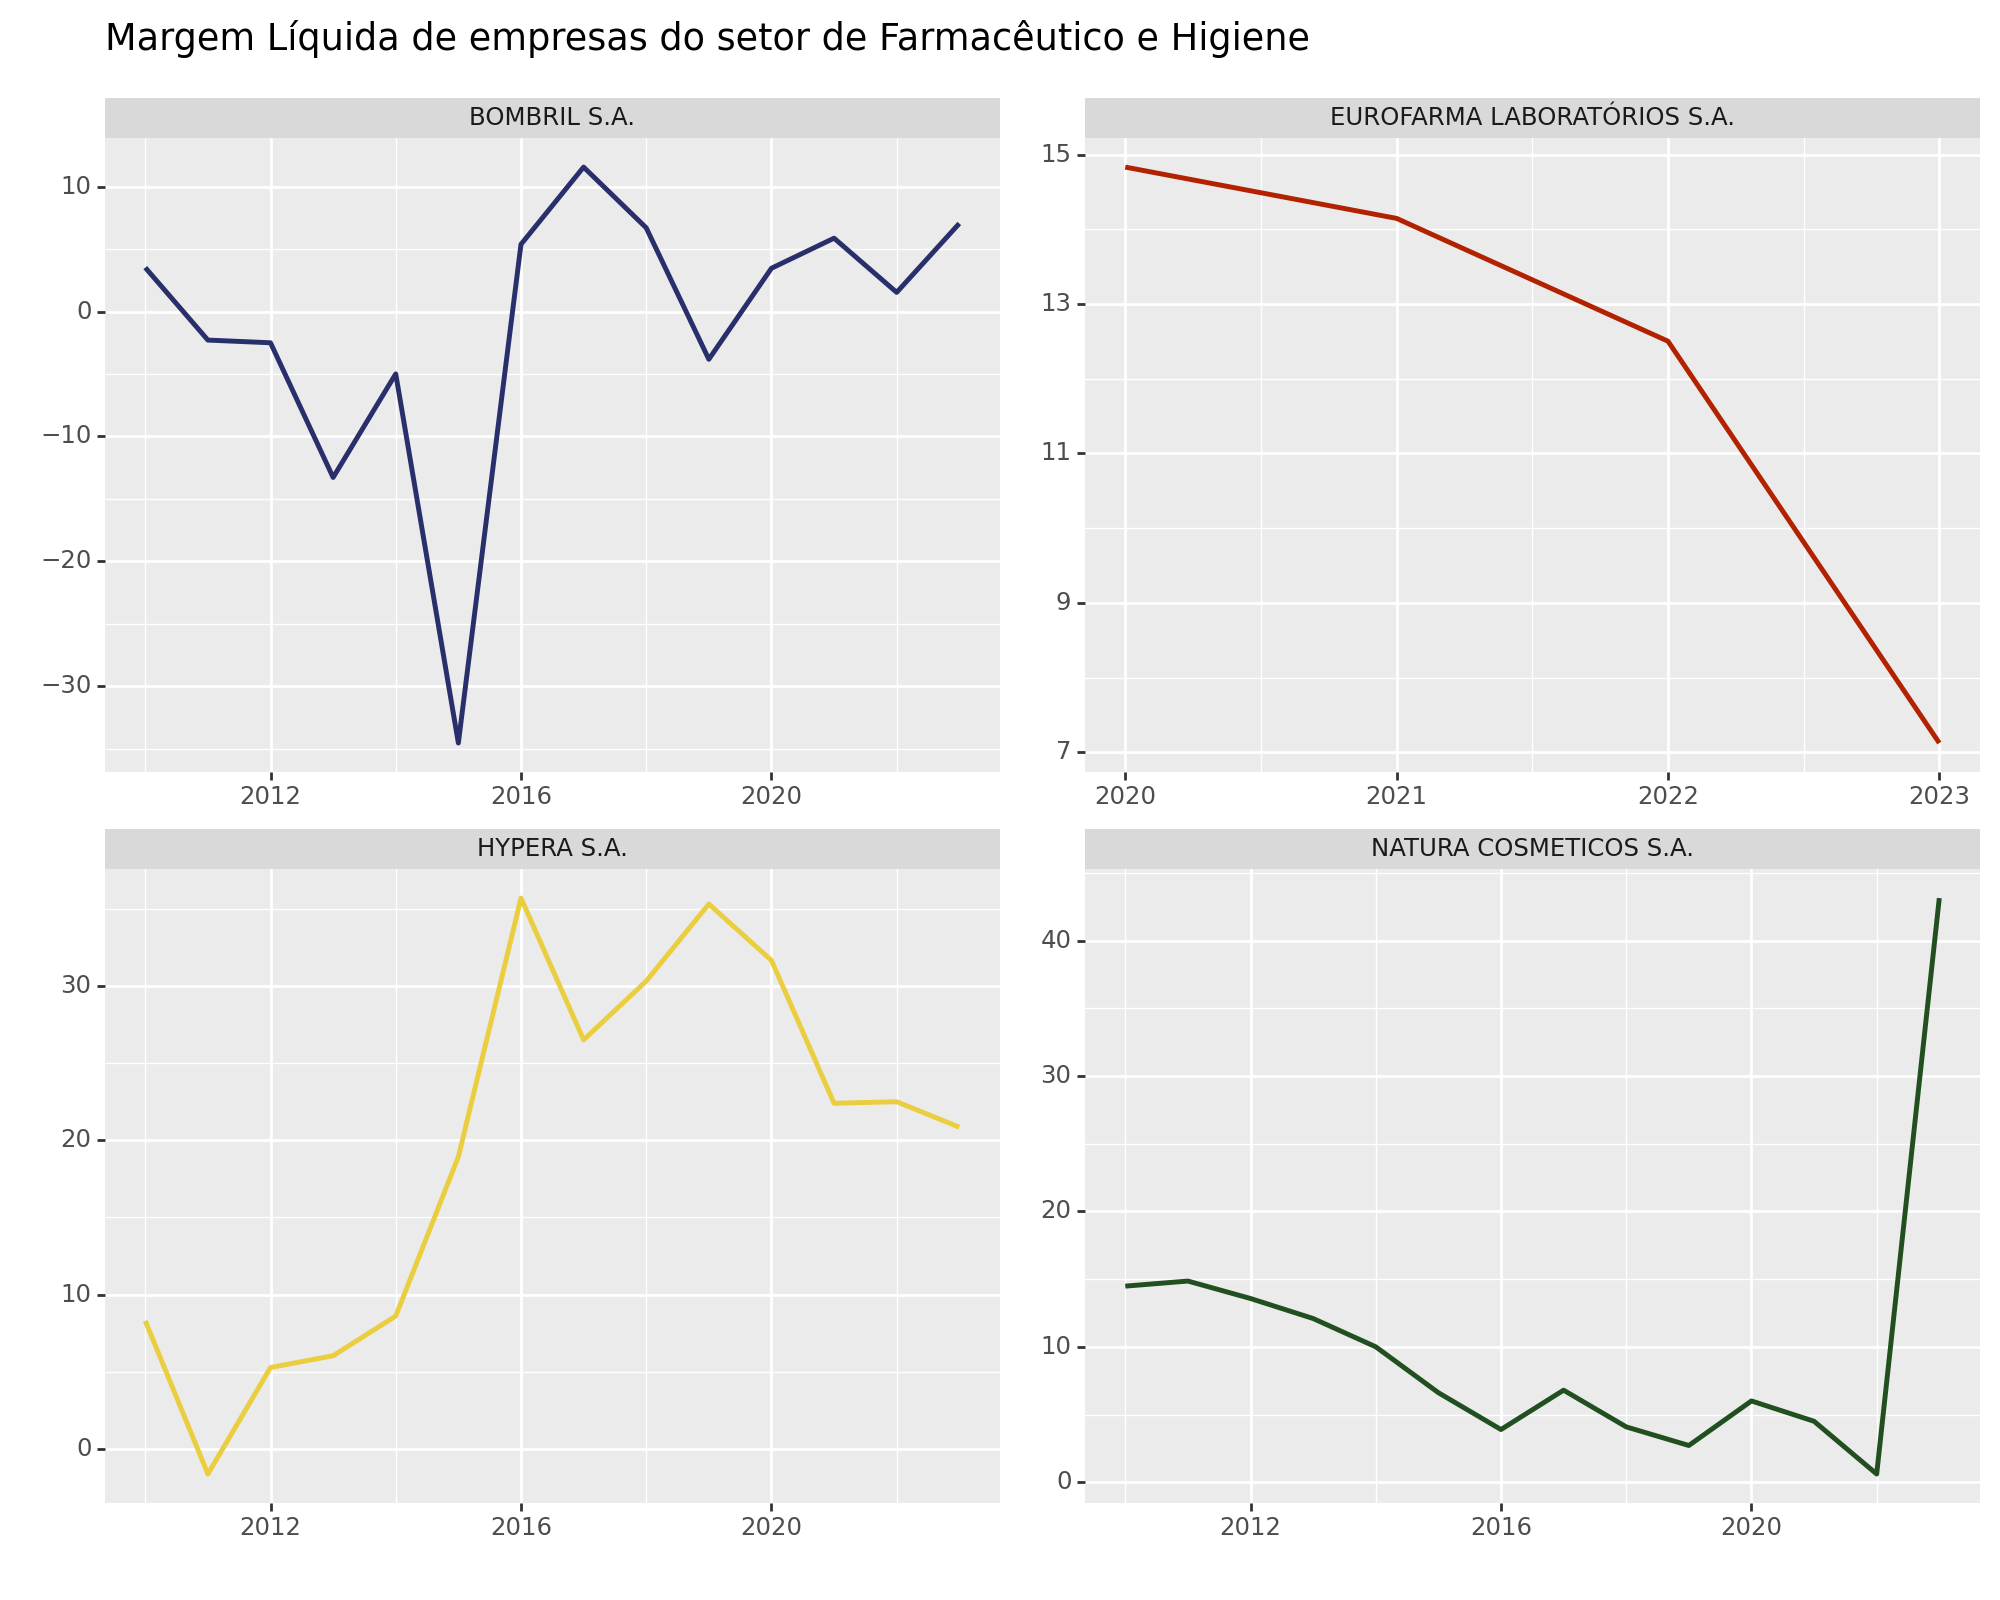

<Figure Size: (1000 x 800)>

In [14]:
# Criando o gráfico
(
    ggplot(indicadores, aes(x = "Ano",
                            y =  "margem_liquida",
                            color = "DENOM_CIA"))
    + geom_line(size = 1)
    + facet_wrap("DENOM_CIA", scales="free")
    + scale_color_manual(values=list(colors.values()))
    + theme()
    + labs(title = "Margem Líquida de empresas do setor de Farmacêutico e Higiene",
           y = '',
           x = '')
    + theme(figure_size=(10, 8),
            subplots_adjust={'wspace': 0.25,
                             'hspace': 0.25},
            legend_position="none")
)